# Multi-Agent Deep Deterministic Policy Gradients (MADDPG)
---
In this notebook, you can see a MADDPG implementation for solving the tennis environment.

### 1. Import the Necessary Packages

In [1]:
from unityagents import UnityEnvironment
import numpy as np
from collections import deque
import torch
import matplotlib.pyplot as plt
%matplotlib inline

import ddpg_agent
from ddpg_agent import Agent, ReplayBuffer

cuda:0


### 2. Start the environment

Next, we will start the environment:

In [2]:
env = UnityEnvironment(file_name='Tennis_Linux/Tennis.x86_64')

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 4. Instantiate the agents

Since they will share the Replay Buffer, instantiate it before.

In [4]:
seed = 10
memory = ReplayBuffer(action_size, ddpg_agent.BUFFER_SIZE, ddpg_agent.BATCH_SIZE, seed)
agents = []
num_agents = 2
for i in range(num_agents):
    agents.append(Agent(state_size=state_size, action_size=action_size, random_seed=seed, memory=memory))

### 5. Train the agent

For every episode, the agent must perform actions and learn from them. The training stops when it reaches an average score of +0.5 over 100 consecutive episodes.

In [5]:
def ddpg(n_episodes=2000, max_t=1000):
    scores_deque = deque(maxlen=100)
    scores = []
    max_score = -np.Inf
    for i_episode in range(1, n_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name] # reset the environment
        states = env_info.vector_observations
        for agent in agents:
            agent.reset()
        score = np.zeros(num_agents)
        while True:
            actions = [agent.act(states[i]) for i, agent in enumerate(agents)]
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations   # get the next state
            rewards = env_info.rewards                   # get the reward
            dones = env_info.local_done                  # see if episode has finished
            for i, agent in enumerate(agents):
                agent.save_memory(states[i], actions[i], rewards[i], next_states[i], dones[i])
            for agent in agents:
                agent.step()
            states = next_states
            score += rewards
            if np.any(dones):
                break 
        max_episode_score = np.max(score)
        scores_deque.append(max_episode_score)
        scores.append(max_episode_score)
        average_scores = np.mean(scores_deque)
        print('\rEpisode {}\tAverage Score: {:.2f}\tScore: {:.2f}'.format(i_episode, average_scores, max_episode_score), end="")
        if i_episode % 100 == 0:
            for i, agent in enumerate(agents):
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_{}.pth'.format(i))
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_{}.pth'.format(i))
            print('\rEpisode {}\tAverage Score: {:.2f}'.format(i_episode, average_scores))   
        if np.mean(scores_deque) >= 0.5:  # consider done when the average score reaches 30 or more
            print('\nEnvironment solved in {:d} episodes!\tAverage Score: {:.2f}'.format(i_episode, average_scores))
            for i, agent in enumerate(agents):
                torch.save(agent.actor_local.state_dict(), 'checkpoint_actor_{}.pth'.format(i))
                torch.save(agent.critic_local.state_dict(), 'checkpoint_critic_{}.pth'.format(i))
            break
    return scores

scores = ddpg()

Episode 100	Average Score: 0.00	Score: 0.00
Episode 200	Average Score: 0.01	Score: 0.00
Episode 300	Average Score: 0.03	Score: 0.00
Episode 400	Average Score: 0.00	Score: 0.00
Episode 500	Average Score: 0.00	Score: 0.00
Episode 600	Average Score: 0.00	Score: 0.00
Episode 700	Average Score: 0.00	Score: 0.00
Episode 800	Average Score: 0.00	Score: 0.00
Episode 900	Average Score: 0.00	Score: 0.00
Episode 1000	Average Score: 0.08	Score: 0.10
Episode 1100	Average Score: 0.09	Score: 0.09
Episode 1200	Average Score: 0.11	Score: 0.09
Episode 1258	Average Score: 0.51	Score: 2.30
Environment solved in 1258 episodes!	Average Score: 0.51


### 6. Plot the scores

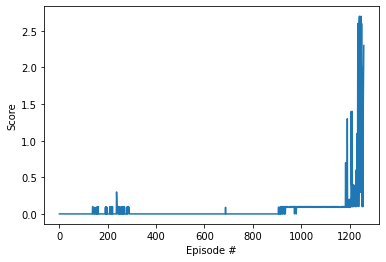

In [6]:
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores)+1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

### 7. Let the trained agents play with the environment!

In [7]:
# load the weights from files
for i, agent in enumerate(agents):
    agent.actor_local.load_state_dict(torch.load('checkpoint_actor_{}.pth'.format(i)))
    agent.critic_local.load_state_dict(torch.load('checkpoint_critic_{}.pth'.format(i)))

env_info = env.reset(train_mode=False)[brain_name] # reset the environment
states = env_info.vector_observations
i = 0
while True:
    actions = [agent.act(states[i]) for i, agent in enumerate(agents)]
    env_info = env.step(actions)[brain_name]
    dones = env_info.local_done
    states = env_info.vector_observations
    
    if np.any(dones):
        print('Done after {} actions'.format(i))
        break
    
    i += 1

Done after 333 actions


### 8. Close the environment

In [8]:
env.close()